<a href="https://colab.research.google.com/github/vinay5751/object_detection/blob/main/multi_class_object_localization_using_VGG16_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Downloding data from kaggle:**
You will need kaggle.json file in order to download this dataset and you have to move that kaggle.json file to kaggle folder.

In [1]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/dog-and-cat-detection

Saving kaggle.json to kaggle.json
100% 1.03G/1.03G [00:06<00:00, 175MB/s]
100% 1.03G/1.03G [00:06<00:00, 179MB/s]


#Extracting Dataset:

In [2]:
from zipfile import ZipFile
from tqdm import tqdm

In [3]:
with ZipFile("/content/dog-and-cat-detection.zip") as zf:
     for member in tqdm(zf.infolist(), desc='Extracting '):
         try:
             zf.extract(member, "/content")
         except zipfile.error as e:
             pass

Extracting : 100%|██████████| 7372/7372 [00:08<00:00, 836.38it/s]


#Converting XML file annotation to Dataframe:
This datafame will consist of all features from filename, features, bounding boxes and labels.

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import imutils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import xml.etree.ElementTree as ET
import glob
import pandas as pd


In [5]:
path = "/content/annotations"
xml_list = []
for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
        try:
            value = (root.find('filename').text,
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        root.find("object")[0].text,
                        int(member[5][0].text),
                        int(member[5][1].text),
                        int(member[5][2].text),
                        int(member[5][3].text)
                        )
            xml_list.append(value)
        except:
            pass
column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
xml_df = pd.DataFrame(xml_list, columns=column_name)

Printing top 5 data.

In [6]:
xml_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Cats_Test1081.png,300,225,cat,84,17,225,160
1,Cats_Test1955.png,300,225,dog,101,13,243,156
2,Cats_Test3131.png,500,375,cat,154,1,347,231
3,Cats_Test1645.png,500,333,dog,224,55,328,151
4,Cats_Test3182.png,366,550,cat,53,312,148,411


#Plotting a rectangle(bounding box) on image:

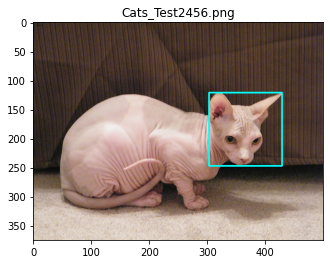

In [7]:
img = cv2.imread('/content/images/Cats_Test2456.png')
color_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.title('Cats_Test2456.png')
color_img = cv2.rectangle(color_img, (303,121), (429,247), (0,255,255), 2) 
plt.imshow(color_img)
plt.show()

#Scaling and plotting both image and bounding box:

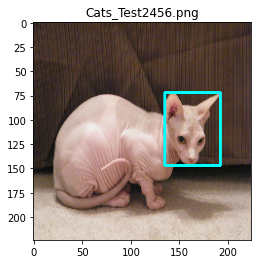

In [8]:
img = cv2.imread('/content/images/Cats_Test2456.png')
color_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
color_img = cv2.resize(color_img,(224,224))
plt.title('Cats_Test2456.png')
color_img = cv2.rectangle(color_img, 
                          (int(303*(224/500)),int(121*(224/375))), 
                          (int(429*(224/500)),int(247*(224/375))), 
                          (0,255,255), 
                          2) 
plt.imshow(color_img)
plt.show()

In [9]:
xml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  3687 non-null   object
 1   width     3687 non-null   int64 
 2   height    3687 non-null   int64 
 3   class     3687 non-null   object
 4   xmin      3687 non-null   int64 
 5   ymin      3687 non-null   int64 
 6   xmax      3687 non-null   int64 
 7   ymax      3687 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 230.6+ KB


In [10]:
xml_df['class'].value_counts()

dog    2498
cat    1189
Name: class, dtype: int64

In [11]:
BASE_PATH = "/content"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])
BASE_OUTPUT = "/content/output"
# define the path to the output model, label binarizer, plots output
# directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "lb.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])
INIT_LR = 1e-4
NUM_EPOCHS = 35
BATCH_SIZE = 32

In [12]:
data = []
labels = []
bboxes = []
imagePaths = []

In [13]:
for index, row in xml_df.iterrows():
    
    imagePath = os.path.join(IMAGES_PATH,row["filename"])
    image = cv2.imread(imagePath)
     #(h, w) = image.shape[:2]
    (h, w) = (row["height"],row["width"])

    startX = float(row["xmin"]) / w
    startY = float(row["ymin"]) / h
    endX = float(row["xmax"]) / w
    endY = float(row["ymax"]) / h

    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    # update our list of data, class labels, bounding boxes, and
    # image paths
    data.append(image)
    imagePaths.append(imagePath)
    labels.append(row["class"])
    bboxes.append((startX, startY, endX, endY))
    

In [14]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2:
    labels = to_categorical(labels)
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [15]:
!mkdir /content/output

In [16]:
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] saving testing image paths...


In [17]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
'''model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())'''

'model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)\nprint(model.summary())'

In [18]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [19]:
import tensorflow as tf

In [20]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))


INFO:tensorflow:Initializing the TPU system: grpc://10.13.132.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.13.132.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [21]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [22]:
with strategy.scope():
    vgg = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
    # freeze all VGG layers so they will *not* be updated during the
    # training process
    vgg.trainable = False
    # flatten the max-pooling output of VGG
    flatten = vgg.output
    flatten = Flatten()(flatten)
    # construct a fully-connected layer header to output the predicted
    # bounding box coordinates
    bboxHead = Dense(128, activation="relu")(flatten)
    bboxHead = Dense(64, activation="relu")(bboxHead)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(4, activation="sigmoid",
    name="bounding_box")(bboxHead)
    # construct a second fully-connected layer head, this one to predict
    # the class label
    softmaxHead = Dense(512, activation="relu")(flatten)
    softmaxHead = Dropout(0.5)(softmaxHead)
    softmaxHead = Dense(512, activation="relu")(softmaxHead)
    softmaxHead = Dropout(0.5)(softmaxHead)
    softmaxHead = Dense(len(lb.classes_), activation="softmax",
    name="class_label")(softmaxHead)
    #model = create_model()
    model = Model(
    inputs=vgg.input,
    outputs=(bboxHead, softmaxHead))
    model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)

'''batch_size = 200
steps_per_epoch = 60000 // batch_size
validation_steps = 10000 // batch_size

train_dataset = get_dataset(batch_size, is_training=True)
test_dataset = get_dataset(batch_size, is_training=False)'''

'''model.fit(train_dataset,
          epochs=5,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_dataset, 
          validation_steps=validation_steps)
'''

58892288/58889256 [==============================] - 0s 0us/step


'model.fit(train_dataset,\n          epochs=5,\n          steps_per_epoch=steps_per_epoch,\n          validation_data=test_dataset, \n          validation_steps=validation_steps)\n'

In [23]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

[INFO] training model...
Epoch 1/35
93/93 [==============================] - 33s 253ms/step - loss: 0.6489 - bounding_box_loss: 0.0237 - class_label_loss: 0.6253 - bounding_box_accuracy: 0.6305 - class_label_accuracy: 0.7015 - val_loss: 0.2494 - val_bounding_box_loss: 0.0088 - val_class_label_loss: 0.2405 - val_bounding_box_accuracy: 0.7669 - val_class_label_accuracy: 0.8984
Epoch 2/35
93/93 [==============================] - 5s 53ms/step - loss: 0.2888 - bounding_box_loss: 0.0073 - class_label_loss: 0.2815 - bounding_box_accuracy: 0.8279 - class_label_accuracy: 0.8767 - val_loss: 0.4085 - val_bounding_box_loss: 0.0078 - val_class_label_loss: 0.4006 - val_bounding_box_accuracy: 0.8144 - val_class_label_accuracy: 0.8306
Epoch 3/35
93/93 [==============================] - 5s 52ms/step - loss: 0.2565 - bounding_box_loss: 0.0051 - class_label_loss: 0.2514 - bounding_box_accuracy: 0.8614 - class_label_accuracy: 0.9019 - val_loss: 0.1909 - val_bounding_box_loss: 0.0077 - val_class_label_loss

In [24]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving object detector model...
[INFO] saving label binarizer...


In [25]:
!mkdir /content/output/plots

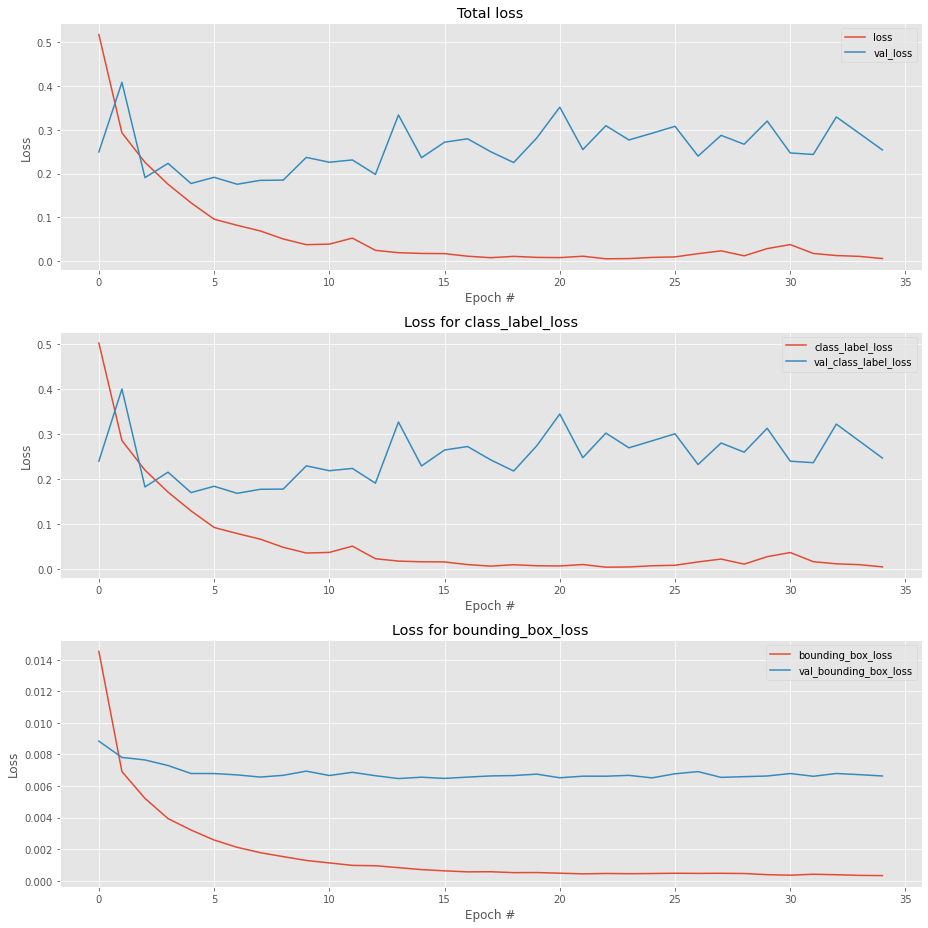

In [26]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([PLOTS_PATH, "losses.png"])
plt.savefig(plotPath)
plt.show()
plt.close()

In [27]:
# load our object detector and label binarizer from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(LB_PATH, "rb").read())

[INFO] loading object detector...


In [28]:
with open('/content/output/test_paths.txt') as f:
    test_filenames = f.read()
imagePaths = []
for f in test_filenames.split("\n"):
    # construct the full path to the image filename and then
    # update our image paths list
    p = os.path.sep.join([f])
    imagePaths.append(p)

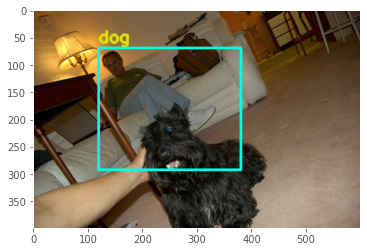

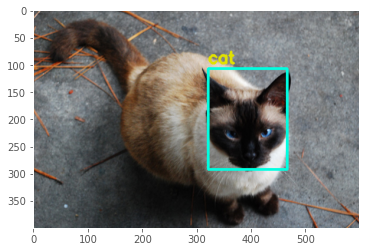

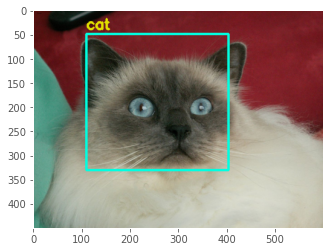

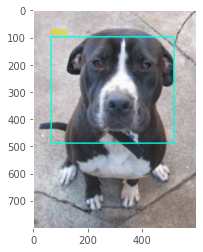

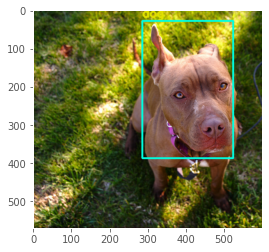

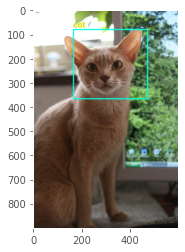

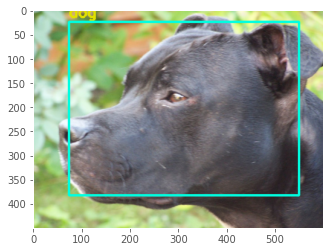

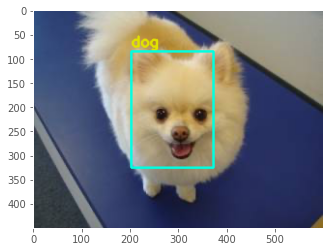

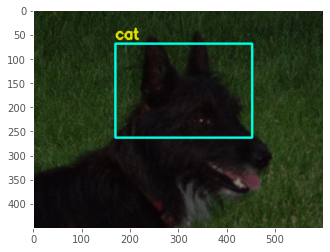

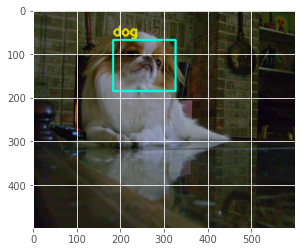

In [29]:
# loop over the images that we'll be testing using our bounding box
# regression model
counter = 0
for imagePath in imagePaths:
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    # predict the bounding box of the object along with the class
    # label
    (boxPreds, labelPreds) = model.predict(image)
    (startX, startY, endX, endY) = boxPreds[0]
    # determine the class label with the largest predicted
    # probability
    i = np.argmax(labelPreds, axis=1)
    label = lb.classes_[i][0]
        # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]
    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    # draw the predicted bounding box and class label on the image
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
        1, (0, 225, 225), 3)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.rectangle(image, (startX, startY), (endX, endY),
        (0, 255, 225), 3)
    # show the output image
    plt.imshow(img)
    counter += 1
    if counter == 10:
        break
    plt.grid(b=None)
    plt.show()